In [1]:
# Import required libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import seaborn as sns
from matplotlib import pylab

sns.set()

In [2]:
import plotly 
plotly.tools.set_credentials_file(username='koshh', api_key='••••••••••')

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
plotly.offline.init_notebook_mode()

In [3]:
# Load dataset
df = pd.read_csv('df.csv').drop(['Unnamed: 0'],axis=1)
df.head()

InvoiceNo StockCode  Quantity          InvoiceDate  UnitPrice CustomerID  \
0    536365    85123A         6  2010-12-01 08:26:00       2.55     C17850   
1    536365     71053         6  2010-12-01 08:26:00       3.39     C17850   
2    536365    84406B         8  2010-12-01 08:26:00       2.75     C17850   
3    536365    84029G         6  2010-12-01 08:26:00       3.39     C17850   
4    536365    84029E         6  2010-12-01 08:26:00       3.39     C17850   

          Country                          Description  CancelledOrder  \
0  United Kingdom   CREAM HANGING HEART T-LIGHT HOLDER               0   
1  United Kingdom                  WHITE METAL LANTERN               0   
2  United Kingdom       CREAM CUPID HEARTS COAT HANGER               0   
3  United Kingdom  KNITTED UNION FLAG HOT WATER BOTTLE               0   
4  United Kingdom       RED WOOLLY HOTTIE WHITE HEART.               0   

   InternationalOrders  TotalPrice  
0                    0       15.30  
1                    0       20.34  
2                    0       22.00  
3                    0       20.34  
4                    0       20.34

## Exploratory Data Analysis

In [4]:
# Load file for plotting on world map
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
pop_est       177 non-null float64
continent     177 non-null object
name          177 non-null object
iso_a3        177 non-null object
gdp_md_est    177 non-null float64
geometry      177 non-null object
dtypes: float64(2), object(4)
memory usage: 8.4+ KB


In [5]:
# Match country names in df dataset and world dataframe

Countries = pd.DataFrame(df.Country.unique(),columns=['Country'])
Countries[~Countries.Country.isin(list(world.name))]

Country
6              EIRE
16  Channel Islands
24        Singapore
28   Czech Republic
31              USA
32          Bahrain
33            Malta
34              RSA

In [6]:
# Sync country names in df and world datasets
df.Country.replace(to_replace={'EIRE':'Ireland','Channel Islands':'United Kingdom','Czech Republic':'Czech Rep.',
                       'RSA':'South Africa','Bahrain':'Saudi Arabia','Malta':'Italy'},inplace=True)
world.name.replace(to_replace={'Malaysia':'Singapore','United States':'USA'},inplace=True)
                       

In [7]:
def plotOnMap(world,colname,title):
    
    colormap = 'magma_r'
    ax = world.plot(column=colname, cmap=colormap, figsize=[18,12], edgecolor='gray', 
                    vmin=min(world[colname]),vmax=max(world[colname]))

    # map marginal/face deco
    ax.set_title('Distribution of International '+title+' (outside UK)',fontsize=17)
    ax.grid() 

    # colorbar will be created by ...
    fig = ax.get_figure()
    # add colorbar axes to the figure
    # here, need trial-and-error to get [l,b,w,h] right
    # l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
    cbax = fig.add_axes([0.95, 0.3, 0.03, 0.39])   
    cbax.set_title('Number of '+title)

    sm = plt.cm.ScalarMappable(cmap=colormap, \
                    norm=plt.Normalize(vmin=min(world[colname]), vmax=max(world[colname])))
    # at this stage, 
    # 'cbax' is just a blank axes, with un needed labels on x and y axes

    # blank-out the array of the scalar mappable 'sm'
    sm._A = []
    # draw colorbar into 'cbax'
    fig.colorbar(sm, cax=cbax, format="%d")

    # dont use: plt.tight_layout()
    plt.show()
    


In [8]:
def plotPie(pie_df,colname,title):
    fig = plt.figure(figsize=(5,5))

    colors = ['navajowhite', 'sandybrown']
    plt.pie(pie_df[colname],labels=pie_df.location,autopct='%1.1f%%',colors=colors)
    plt.title(title.title()+' Percentage in UK and outside UK')
    
    plt.tight_layout()
    plt.show()

In [9]:
def addToWorld(world,col,colname,title):
    '''
    Plots the 'col' values on world map
    ----------------
    Input:
        world: geopandas dataset to be used
        col: column whose count is to be added to the 'world' dataset
        colname: name of the new aggregated column in the 'world' dataset
        title: the measure which is to be plotted
    ----------------
    '''
    if col==None:
        temp_df = df[df.CancelledOrder==1].Country.value_counts().to_frame(colname).reset_index()
    else:
        temp_df = df.groupby(['Country',col],as_index=False).count().Country.value_counts().to_frame(colname).reset_index()
    
    world = pd.merge(world, temp_df, left_on='name', right_on='index', how='left', validate='one_to_one')

    world.drop('index', axis=1, inplace=True)
    world[colname].fillna(0,inplace=True)
    
    temp_df['location'] = np.where(temp_df['index']=='United Kingdom', 'UK', 'Rest of the World')
    pie_df = temp_df.groupby(['location'],as_index=False)[colname].sum()
    plotPie(pie_df,colname,title)
    
    world.loc[world.name=='United Kingdom',colname] = 0
    plotOnMap(world,colname,title)

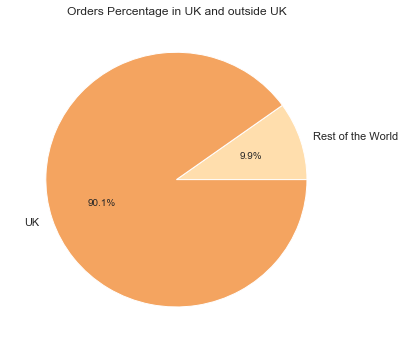

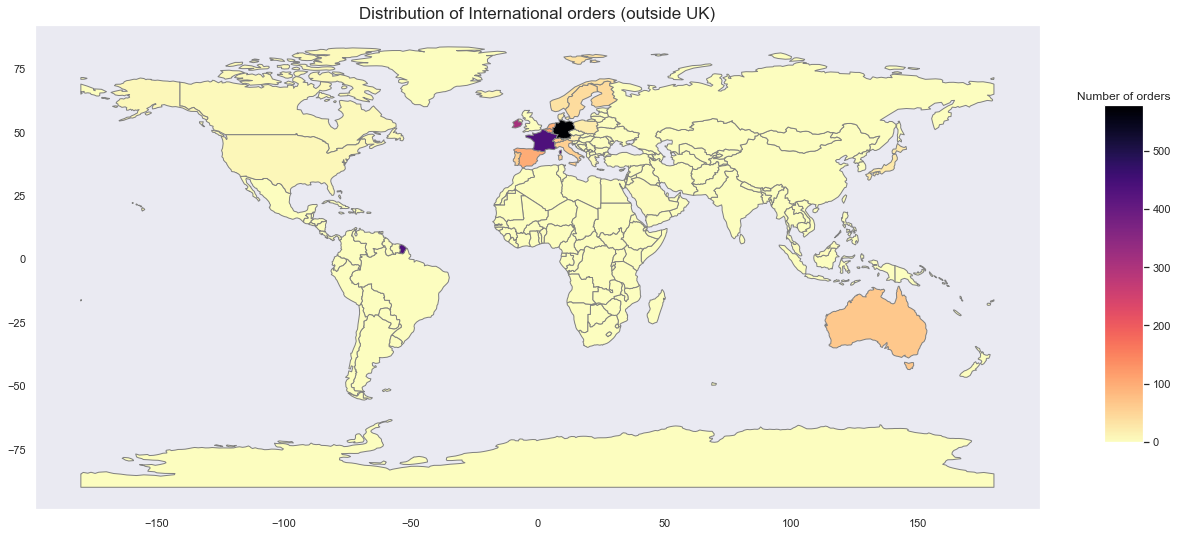

In [10]:
addToWorld(world,'InvoiceNo','TotalOrders','orders')

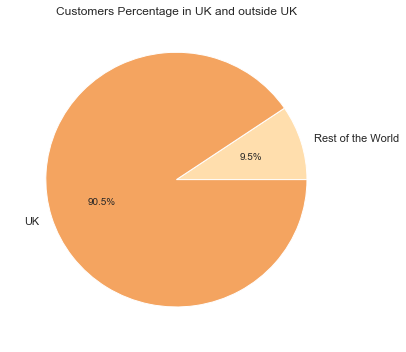

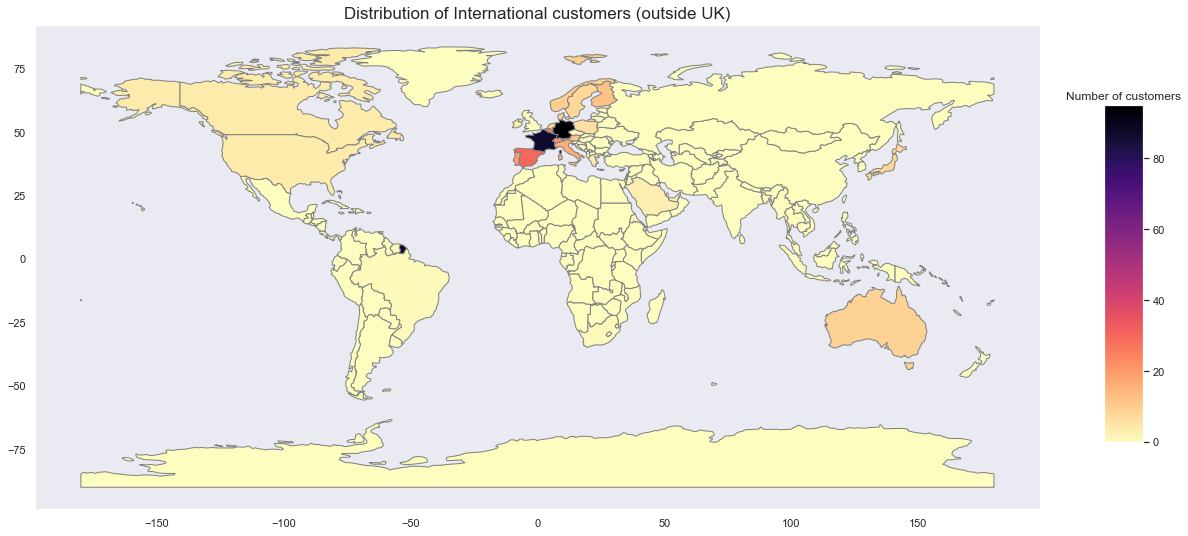

In [11]:
addToWorld(world,'CustomerID','TotalCust','customers')

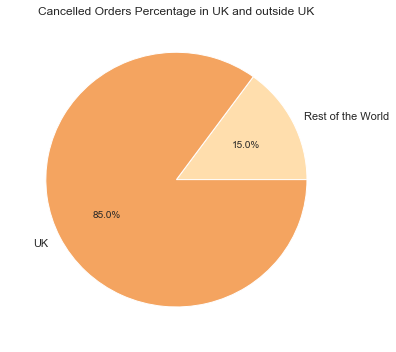

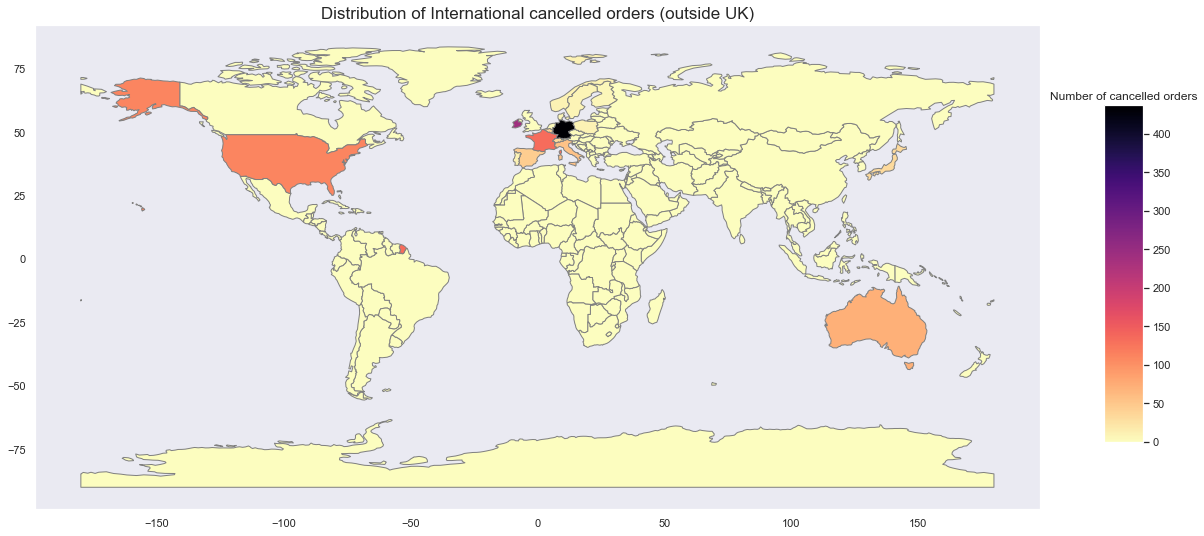

In [12]:
addToWorld(world,None,'Cancelled','cancelled orders')

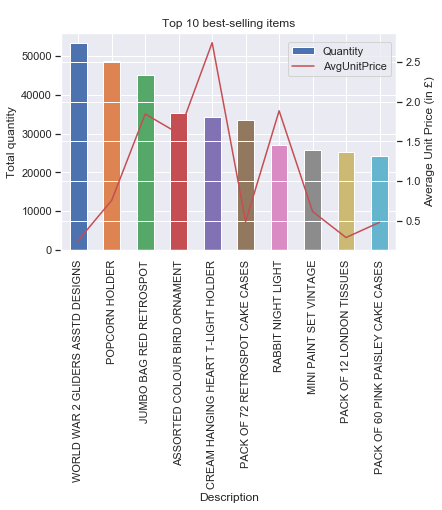

In [13]:
# Find the 10 best-selling items

Top10Qty = df.groupby('Description',as_index=False)['Quantity','TotalPrice'].sum().sort_values(by='Quantity',
                                                                                               ascending=False).head(10)
Top10Qty['AvgUnitPrice'] = Top10Qty.TotalPrice/Top10Qty.Quantity

# Plot top 10 most popular items

ax = Top10Qty.plot(x="Description", y="Quantity", legend=False,kind='bar')
ax2 = ax.twinx()
Top10Qty.plot(x="Description", y="AvgUnitPrice", ax=ax2, legend=False, color="r")
ax.figure.legend(loc=(.65,.85))
plt.title('Top 10 best-selling items')
ax.set_ylabel('Total quantity')
ax2.set_ylabel('Average Unit Price (in £)')
plt.show()

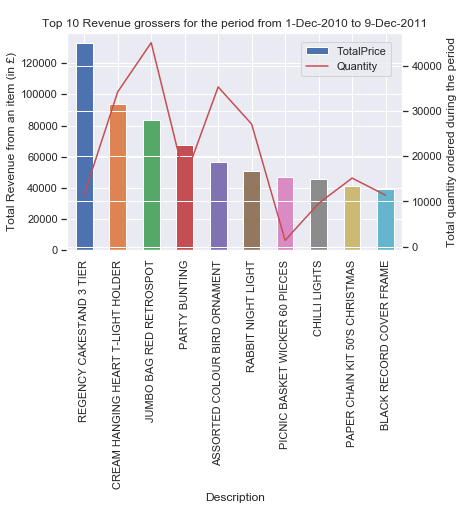

In [14]:
# Top 10 revenue grossing items

Top10Rev = df.groupby('Description',as_index=False)['TotalPrice','Quantity'].sum().sort_values(by='TotalPrice',
                                                                                               ascending=False).head(10)
Top10Rev['AvgUnitPrice'] = Top10Rev.TotalPrice/Top10Rev.Quantity

# Total Revenue
TotalRev = round(df.TotalPrice.sum(),0)

# Plot top 10 revenue grossers
ax = Top10Rev.plot(x="Description", y="TotalPrice", legend=False,kind='bar')
ax2 = ax.twinx()
Top10Rev.plot(x="Description", y="Quantity", ax=ax2, legend=False, color="r")
# ax.axhline(TotalRev, c='k', ls='--')
ax.figure.legend(loc=(.65,.85))
plt.title('Top 10 Revenue grossers for the period from 1-Dec-2010 to 9-Dec-2011')
ax.set_ylabel('Total Revenue from an item (in £)')
ax2.set_ylabel('Total quantity ordered during the period')
plt.show()

In [15]:
# Number of unique items and customers

print(len(df.Description.unique()))
print(len(df.CustomerID.unique()))

3652
4357


### Pareto Principle

The Pareto principle (also known as the 80/20 rule) states that, for many events, roughly 80% of the effects come from 20% of the causes.(Source: wikipedia)

For a sales entity, Pareto pinciple could suggest that 80% sales of a company comes from 20% of its products and/or 80% of its sales comes from 20% of its customers.

Our online retail store has 3652 unique items for sale, and 4357 unique customers for the period from Dec 1 2010 to Dec 9 2011. Here, Pareto principle is of value because instead of focussing on such a huge number of items and customers, the company needs to just focus on 20% of these in order to effect 80% of its sales.

Let us check the applicability of Pareto principle for our dataset.

In [16]:
# # Pareto principle

# pareto_df = df.groupby('Description',as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice', ascending=False)
# pareto_df['cumulative_sum'] = pareto_df.TotalPrice.cumsum()
# pareto_df['cumulative_perc'] = 100*pareto_df.cumulative_sum/pareto_df.TotalPrice.sum()
# pareto_df.head()

In [17]:
# pareto_threshold = int(len(pareto_df)*.20)
# pareto_df.head(pareto_threshold).tail(1)

In [18]:
# # Graphical representation of Pareto Principle
# pareto_df['demarcation'] = 80

# trace1 = Bar(x=pareto_df.Description,y=pareto_df.TotalPrice, name='Sales Revenue', marker=dict(color='rgb(34,163,192)'))
# trace2 = Scatter(
#     x=pareto_df.Description,
#     y=pareto_df.cumulative_perc,
#     name='Cumulative Percentage',
#     yaxis='y2',
#     line=dict(
#         color='rgb(243,158,115)',
#         width=2.4
#        )
# )
# trace3 = Scatter(
#     x=pareto_df.Description,
#     y=pareto_df.demarcation,
#     name='80%',
#     yaxis='y2',
#     line=dict(
#         color='rgba(128,128,128,.45)',
#         dash = 'dash',
#         width=1.5
#        )
# )
# trace4 = Scatter(
#     x=[pareto_df.head(pareto_threshold).tail(1).Description],
#     y=[120000],
#     text=['20% of items'],
#     mode='text',
# )

# data = [trace1, trace2, trace3, trace4]

# layout = Layout(title='Itemwise sales revenue from 1-Dec-2010 to 9-Dec-2011', 
#                 titlefont=dict(color='black', family='Balto, sans-serif', size=12), 
#                 font=Font(color='rgb(128,128,128)', family='Balto, sans-serif', size=12), width=1500, height=623, 
#                 paper_bgcolor='rgb(240, 240, 240)', plot_bgcolor='rgb(240, 240, 240)', hovermode='closest', 
#                 margin=dict(b=250,l=60,r=60,t=65), showlegend=True, 
#                 legend=dict(x=.83, y=1.3, font=dict(family='Balto, sans-serif', size=12, color='rgba(128,128,128,.75)'),),
#                 annotations=[ dict(text="Cumulative Percentage", showarrow=False, xref="paper", yref="paper", textangle=90, 
#                                    x=1.029, y=.75, font=dict(family='Balto, sans-serif', size=14, color='rgba(243,158,115,.9)'),
#                                   )], 
#                 shapes=[{'type':'line', 'x0':pareto_threshold,'y0':0,'x1':pareto_threshold,'y1':120000,
#                          'line':{'color':'rgb(128,128,128,.45)','dash':'dot','width': 1.5}}],
#                 xaxis=dict(tickangle=-90), 
#                 yaxis=dict(title='Sales (in £)', range=[0,130500], 
#                                                       tickfont=dict(color='rgba(34,163,192,.75)'),
#                                                       tickvals = [0,26000,52000,77500,100000,120000], 
#                                                       titlefont=dict(family='Balto, sans-serif', size=14,
#                                                                      color='rgba(34,163,192,.75)')), 
#                 yaxis2=dict(range=[0,101], tickfont=dict(color='rgba(243,158,115,.9)'), tickvals = [0,20,40,60,80,100],
#                             overlaying='y', side='right'))

# fig = dict(data=data, layout=layout)
# iplot(fig)

In [19]:
def applyPareto(df,column_20, measure):
    '''
    Checks the contribution of 20% of a cause to 80% of sales revenue
     ----------------
    Input:
        df: dataset on which Pareto principle is to be checked
        column_20: column to be checked for 20% of its unique entries to affect 80% of sales
        measure: string - the measure that is conributing to 80%
    ----------------
    '''
    pareto_df = df.groupby(column_20,as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice', ascending=False)
    pareto_df['cumulative_sum'] = pareto_df.TotalPrice.cumsum()
    pareto_df['cumulative_perc'] = 100*pareto_df.cumulative_sum/pareto_df.TotalPrice.sum()
    
    item_perc = round(len(pareto_df[(pareto_df.cumulative_perc)<80])/len(pareto_df)*100)

    print(item_perc,'% of',measure,'contribute to 80% of sales')
    print(item_perc,'% means',round(item_perc/100*len(pareto_df)),measure)
    
    plotPareto(pareto_df, column_20,measure)
    
def plotPareto(pareto_df,column_20,measure):
    '''
    Displays applicability of Pareto Principle on a dataset
    '''
    # Graphical representation of Pareto Principle
    pareto_df['demarcation'] = 80
    pareto_threshold = int(len(pareto_df)*.20)


    trace1 = Bar(x=pareto_df[column_20],y=pareto_df.TotalPrice, name='Sales Revenue', marker=dict(color='rgb(34,163,192)'))
    trace2 = Scatter(
        x=pareto_df[column_20],
        y=pareto_df.cumulative_perc,
        name='Cumulative Percentage',
        yaxis='y2',
        line=dict(
            color='rgb(243,158,115)',
            width=2.4
           )
    )
    trace3 = Scatter(
        x=pareto_df[column_20],
        y=pareto_df.demarcation,
        name='80%',
        yaxis='y2',
        line=dict(
            color='rgba(128,128,128,.45)',
            dash = 'dash',
            width=1.5
           )
    )
    trace4 = Scatter(
        x=[pareto_df.head(pareto_threshold).tail(1)[column_20]],
        y=[round(max(pareto_df.TotalPrice))*.90],
        text=['20% of items'],
        mode='text',
    )

    data = [trace1, trace2, trace3, trace4]
    
    layout = Layout(title=measure+'wise sales revenue from 1-Dec-2010 to 9-Dec-2011', 
                    titlefont=dict(color='black', family='Balto, sans-serif', size=12), 
                    font=Font(color='rgb(128,128,128)', family='Balto, sans-serif', size=12), width=1500, height=623, 
                    paper_bgcolor='rgb(240, 240, 240)', plot_bgcolor='rgb(240, 240, 240)', hovermode='closest', 
                    margin=dict(b=250,l=60,r=60,t=65), showlegend=True, 
                    legend=dict(x=.83, y=1.3, font=dict(family='Balto, sans-serif', size=12, color='rgba(128,128,128,.75)'),),
                    annotations=[ dict(text="Cumulative Percentage", showarrow=False, xref="paper", yref="paper", textangle=90, 
                                       x=1.029, y=.75, font=dict(family='Balto, sans-serif', size=14, color='rgba(243,158,115,.9)'),
                                      )], 
                    shapes=[{'type':'line', 'x0':pareto_threshold,'y0':0,'x1':pareto_threshold,'y1':round(max(pareto_df.TotalPrice)),
                             'line':{'color':'rgb(128,128,128,.45)','dash':'dot','width': 1.5}}],
                    xaxis=dict(tickangle=-90), 
                    yaxis=dict(title='Sales (in £)', range=[0,round(max(pareto_df.TotalPrice))], dtick=1,
                                                          tickfont=dict(color='rgba(34,163,192,.75)'),
                                                          tickvals = np.linspace(0,max(round(pareto_df.TotalPrice)),6), 
                                                          titlefont=dict(family='Balto, sans-serif', size=14,
                                                                         color='rgba(34,163,192,.75)'),tickformat='.0f'), 
                    yaxis2=dict(range=[0,101], tickfont=dict(color='rgba(243,158,115,.9)'), tickvals = [0,20,40,60,80,100],
                                overlaying='y', side='right'))

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [20]:
applyPareto(df,'Description','items')


22 % of items contribute to 80% of sales
22 % means 803 items


C:\Users\sony\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:318: DeprecationWarning:

plotly.graph_objs.Font is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Font
  - plotly.graph_objs.layout.hoverlabel.Font
  - etc.




Pareto principle holds true for items in our dataset, as 22% of all the items are contributing to 80% of the sales revenue. 22% of all items means 803 items.

In [21]:
applyPareto(df,'CustomerID','customers')

27 % of customers contribute to 80% of sales
27 % means 1176 customers


C:\Users\sony\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:318: DeprecationWarning:

plotly.graph_objs.Font is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Font
  - plotly.graph_objs.layout.hoverlabel.Font
  - etc.




27% of all the customers are contributing to 80% of the sales revenue. 27% of all items means 1176 items.

### Time Series plots

In [22]:
sales = df.groupby('InvoiceDate')['TotalPrice'].sum()
sales.index = pd.to_datetime(sales.index)


In [23]:
def plotSales(sales,time_freq,xtick,freq):
    trend = sales.resample(time_freq).sum()
    holidays = ['2010-12-27', '2010-12-28', '2011-01-03', '2011-04-22', '2011-04-25', '2011-04-29', '2011-05-02',
            '2011-05-30', '2011-08-29']

    fig = plt.figure(figsize=(20, 5))

    plt.plot(trend)

    dates = trend.index[::xtick]
    labels = dates.strftime('%b %d %H:%M %A')
    
    if time_freq!='H':
        [pylab.axvline(_x, linewidth=1, color='r',ls='--') for _x in holidays]
        labels = dates.strftime('%b %d')

    plt.xticks(dates, labels, rotation=90)
    plt.legend(['TotalPrice','UK Holidays'])
    plt.title(freq+' sales from Dec-1-2010 to Dec-09-2011')
    plt.show()

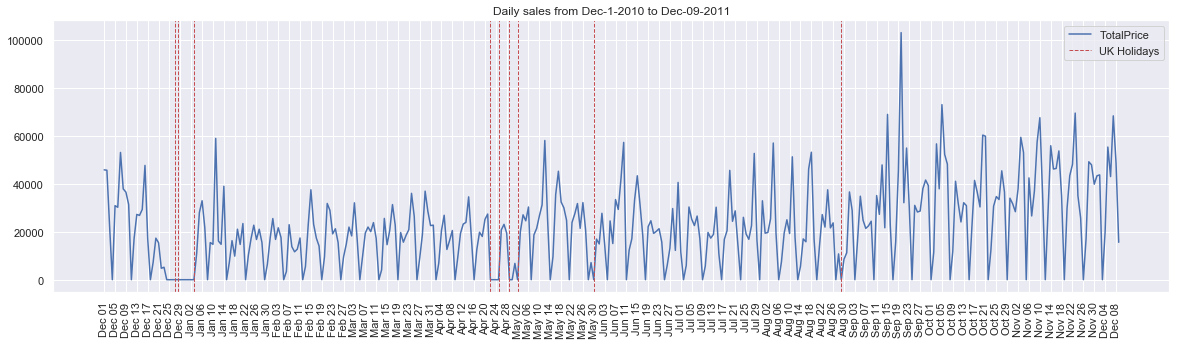

In [24]:
plotSales(sales,'D',4,'Daily')

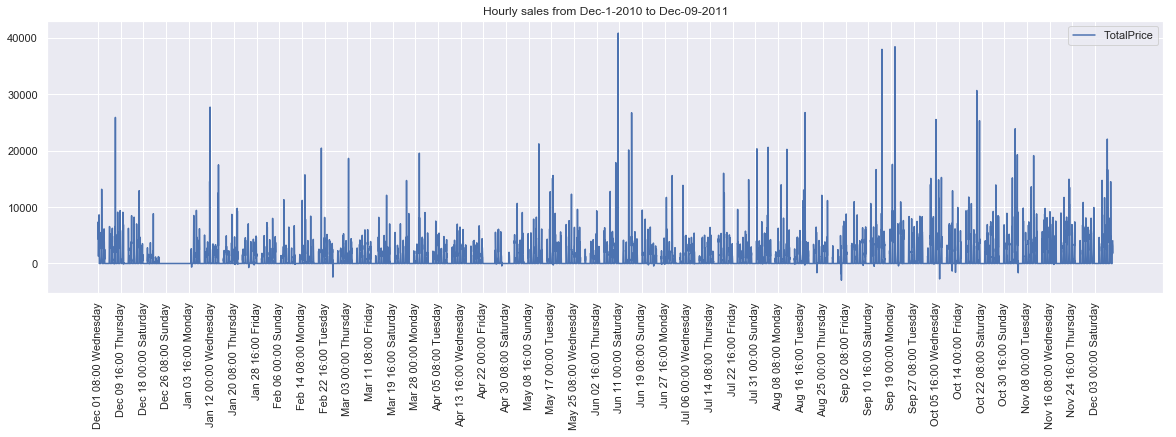

In [25]:
plotSales(sales,'H',200,'Hourly')

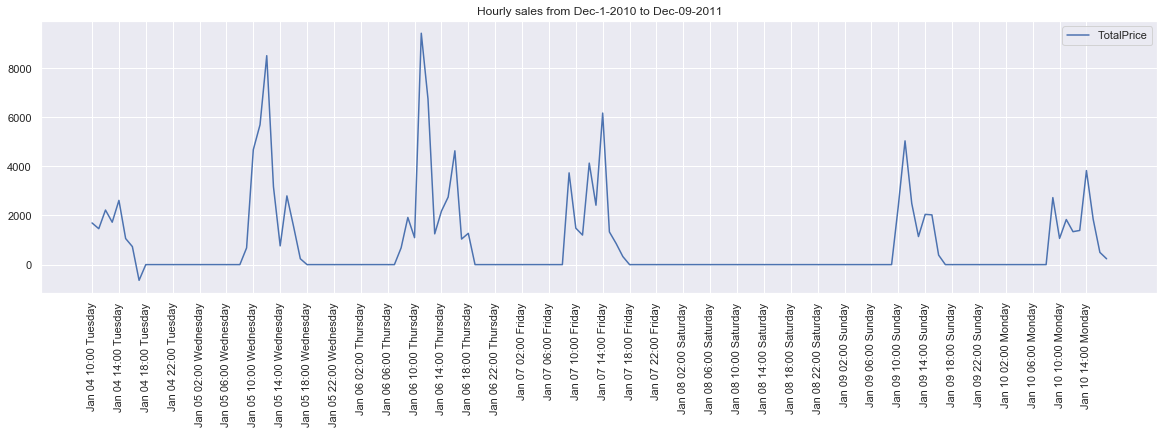

In [26]:
plotSales(sales['2011-01-01':'2011-01-10'],'H',4,'Hourly')

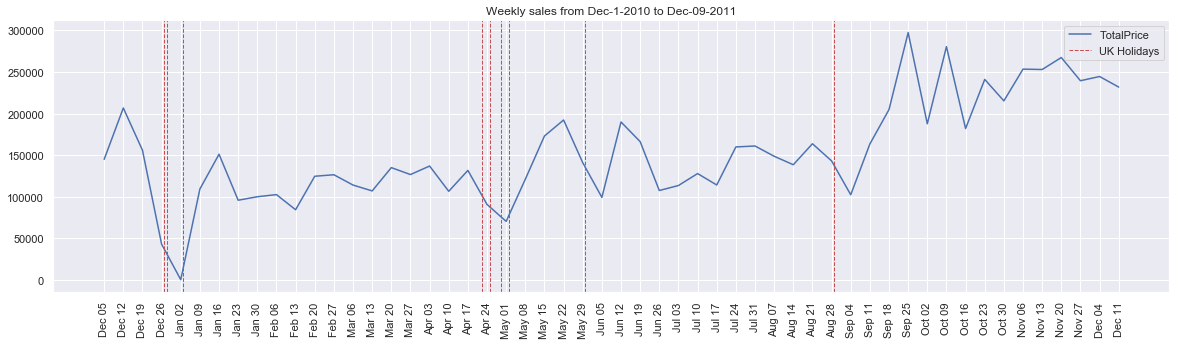

In [27]:
plotSales(sales,'W',1,'Weekly')

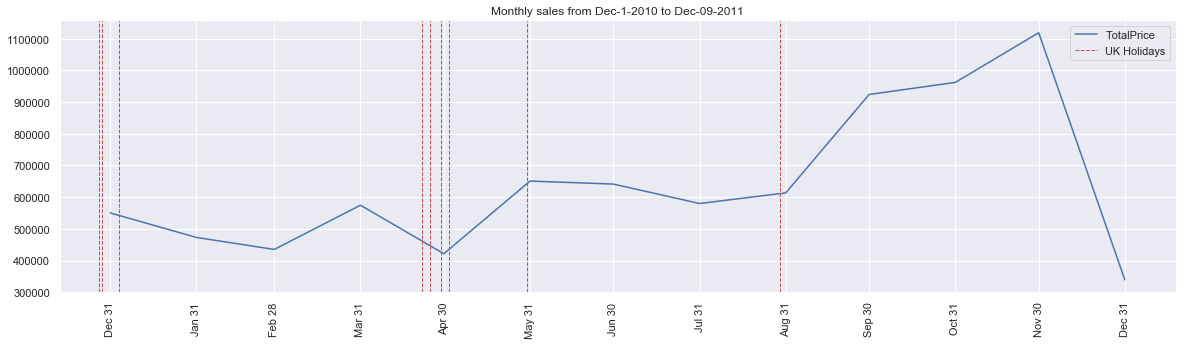

In [28]:
plotSales(sales,'M',1,'Monthly')

### Observations

1. There is no sales happening on Saturdays.
1. Sales falls down during the holidays
1. There is zero sales happening on Boxing day (Dec 26th) which probably means that the company does not offer any promotions during the holidays/special days.
1. Sales happens only during the working hours - between 8am and 6pm.
1. There is no particular trend seen in monthly and weekly sales. The overall sales has increased through the months.

In [29]:
df.to_csv('orders.csv')